In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from ast import literal_eval
from html.parser import HTMLParser
import pickle
from nltk import sent_tokenize, word_tokenize
import random
from collections import Counter
import matplotlib.pyplot as plt
import json

tqdm().pandas()

In this notebook, I collected the data from the Acrolinx blog posts, funnelled it into a shape usable with the Doccano annotation tool, and after that tool was used re-collected the annotated data and ran some tests and statistics on it.

# Access Data

The blog posts were provided in one large XML file. I parsed this file and separated out the posts, with the relevant metadata, into a pandas DataFrame.

In [37]:
acrofile = 'data/acrolinx_blog/acrolinx.WordPress.2019-05-21.xml'

In [38]:
tree = ET.parse(acrofile)
root = tree.getroot()
channel = tree.find('channel')

In [39]:
titles = []
dates = []
categories = []
texts = []

for item in channel:
    if item.tag == 'item':
        titles.append(item.find('title').text)
        dates.append(item.find('pubDate').text)
        
        texts.append(item.find('{http://purl.org/rss/1.0/modules/content/}encoded').text)
        
        cats = []
        for child in item:
            if child.tag == 'category':
                cats.append(child.text)
        categories.append(list(set(cats)))

In [40]:
assert len(titles) == len(dates) == len(categories) == len(texts)

In [41]:
df = pd.DataFrame({'title': titles, 
                  'pubdate': dates,
                  'cats': categories,
                  'text': texts})

In [42]:
df.head()

,cats,pubdate,text,title
0,"[Blog, Tech Comm, Content Marketing]","Thu, 20 Nov 2014 12:49:29 +0000",Imagine that you’ve just written what you beli...,10 Questions You’ve Got to Ask Yourself Before...
1,"[Tech Comm, Blog, Love of Language, Content Ma...","Mon, 17 Nov 2014 12:51:04 +0000","We recently shared <a href=""https://www.acroli...",Problem Words that Give Writers Trouble (Part 2)
2,"[Tech Comm, Blog, Love of Language, Content Ma...","Thu, 13 Nov 2014 12:52:27 +0000",Even the best writers can get tripped up somet...,Problem Words that Give Writers Trouble (Part 1)
3,"[Tech Comm, Blog, Love of Language, Content Ma...","Mon, 10 Nov 2014 12:55:17 +0000",Part of being a good content marketer is being...,6 Great Free (or Nearly Free) Tools for Conten...
4,"[Tech Comm, Blog, Love of Language, Content Ma...","Fri, 07 Nov 2014 12:57:14 +0000",Have you ever heard of Amy Cuddy? In addition ...,Why Writers Should Care About Their Posture


In [54]:
df.to_pickle('data/acrolinx_blog/blog_whole_texts.pkl')

# Pre-processing

The data was cleaned before splitting into sentences: HTML tags were removed and other minor issues were cleared.

In [44]:
# remove HTML tags
# https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

df['text'] = df['text'].apply(strip_tags)

In [45]:
def clean_text(text):
    text = text.replace('\n', ' ')
    text = text.strip()
    text = text.replace('’', "'")
    text = text.replace('“', '"')
    text = text.replace('”', '"')
    text = text.replace('\xa0', '')
    text = text.replace('\t', '')
    text = text.replace("\\", "")
    return text

df.text = df.text.apply(clean_text)

In [167]:
df.to_pickle('data/acrolinx_blog.pkl')

## Side question: how many sentences are in the dataset?

In [168]:
sents = []

for text in df.text:
    sents = sents + sent_tokenize(text)

In [169]:
len(sents)

10919

# Prepare for OpenNMT

To do the planned informal to formal translation, the text had to be put in a txt file with each sentence in a new line.

In [171]:
with open('data/OpenNMT files/src-acrolinx.txt', 'w') as f:
    for sent in sents:
        if len(sent) > 5:
            f.write(' '.join(word_tokenize(sent)) + '\n')

# Examine OpenNMT results

First, a brief look at the model's output is desired.

In [2]:
with open('data/OpenNMT files/src-acrolinx.txt', 'r') as f:
    src = f.readlines()

with open('data/OpenNMT files/pred-acrolinx.txt', 'r') as f:
    pred = f.readlines()

In [3]:
src = [x.strip() for x in src]
pred = [x.strip() for x in pred]

In [4]:
assert len(src) == len(pred)

In [5]:
for idx in random.sample(range(len(src)), 10):
    print(src[idx])
    print(pred[idx])
    print()

Not only do you understand what the authors are trying to convey , you also get the sense that MailChimp is n't some big , soulless corporation .
Do you understand what the authors are trying to convey ? You also get the sense of soulless , soulless corporation .

It 's also where technical content faces the biggest challenges as a result of three converging trends : A rapid acceleration in software development cycles , including online launches Online hosting with embedded content , where bite-sized content produced at frequent intervals is replacing massive tome-sized documents produced over the course of many months An aspiration for localized content in multiple languages timed with product releases Let 's consider these trends , and their implications for technical content , individually .
In multiple languages , it 's technical content faces , the biggest challenges faces , a result of three months is content produced in software releases so I can understand technical content .



# Prepare for Doccano

Next we want to use Doccano to manually select the spans of the sentences which are properly translated and remain within their fragments. We must save the data in CSV format in order to upload it into Doccano.

In [7]:
doccano = pd.DataFrame()

texts = []
for idx in range(len(src)):
    texts.append(src[idx] + ' ' + pred[idx])

In [9]:
doccano['text'] = texts
doccano.head()

,text
0,Imagine that you 've just written what you bel...
1,You 're ready to get it off your plate and sen...
2,"But wait just a second ! But , wait , a second !"
3,"Before you hit the publish button , are you po..."
4,"After all , you 've probably worked hard to cr..."


In [14]:
doccano.to_csv('data/doccano.csv')

# post-Doccano: put results into dataframe

After the doccano work is complete, some work needs to be done to process the annotations into a format more easily explored and used (for me, a pandas DataFrame).

In [31]:
with open('data/opennmt/src-acrolinx.txt', 'r') as f:
    src = f.readlines()
src = [x.strip() for x in src]

In [28]:
ann = pd.read_json('data/acrolinx_blog/acrolinxblog_annotated.json', lines=True)

In [32]:
ann['source'] = src

In [33]:
ann.head()

,annotations,id,meta,text,source
0,"[{'label': 1, 'user': 1, 'start_offset': 15, '...",2,{},"0,Imagine that you 've just written what you b...",Imagine that you 've just written what you bel...
1,"[{'label': 1, 'user': 1, 'start_offset': 2, 'e...",3,{},"1,You 're ready to get it off your plate and s...",You 're ready to get it off your plate and sen...
2,[],4,{},"2,""But wait just a second ! But , wait , a sec...",But wait just a second !
3,"[{'label': 1, 'user': 1, 'start_offset': 61, '...",5,{},"3,""Before you hit the publish button , are you...","Before you hit the publish button , are you po..."
4,"[{'label': 1, 'user': 1, 'start_offset': 15, '...",6,{},"4,""After all , you 've probably worked hard to...","After all , you 've probably worked hard to cr..."


In [95]:
edits = []
tbd = []
num = 0

for idx, row in tqdm(ann.iterrows(), total=len(ann)):
    if row['annotations'] == []:
        edits.append(None)
    else:
        current_edits = []        
        # count number of annotations made
        num += len(row['annotations'])
        
        # split annotations into informal and formal changes
        inform_ann = []
        formal_ann = []
        for note in row['annotations']:
            if note['label'] == 1:
                inform_ann.append(note)
            elif note['label'] == 2:
                formal_ann.append(note)
                
        # set aside some to deal with later
        if len(inform_ann) != len(formal_ann):
            tbd.append((idx, row['annotations']))
            edits.append('None')
            continue
        elif inform_ann[-1]['end_offset'] > formal_ann[0]['start_offset']:
            tbd.append((idx, row['annotations']))
            edits.append('None')
            continue
            
        assert len(inform_ann) == len(formal_ann)
        for x in range(len(inform_ann)): # pairs of edits
            inform = row['text'][inform_ann[x]['start_offset']:inform_ann[x]['end_offset']]
            formal = row['text'][formal_ann[x]['start_offset']:formal_ann[x]['end_offset']]
            current_edits.append((inform.strip(), formal.strip()))
        edits.append(current_edits)
        
ann['edits'] = edits
print(num)
print(tbd)


9813
[(20, [{'label': 2, 'end_offset': 17, 'user': 1, 'start_offset': 4}, {'label': 1, 'end_offset': 161, 'user': 1, 'start_offset': 147}]), (32, [{'label': 2, 'end_offset': 33, 'user': 1, 'start_offset': 3}, {'label': 1, 'end_offset': 86, 'user': 1, 'start_offset': 57}]), (183, [{'label': 1, 'end_offset': 75, 'user': 1, 'start_offset': 57}, {'label': 1, 'end_offset': 200, 'user': 1, 'start_offset': 182}, {'label': 1, 'end_offset': 100, 'user': 1, 'start_offset': 89}, {'label': 2, 'end_offset': 228, 'user': 1, 'start_offset': 215}]), (265, [{'label': 2, 'end_offset': 12, 'user': 1, 'start_offset': 5}, {'label': 1, 'end_offset': 202, 'user': 1, 'start_offset': 197}]), (275, [{'label': 2, 'end_offset': 131, 'user': 1, 'start_offset': 77}, {'label': 1, 'end_offset': 237, 'user': 1, 'start_offset': 202}]), (547, [{'label': 2, 'end_offset': 18, 'user': 1, 'start_offset': 4}, {'label': 1, 'end_offset': 146, 'user': 1, 'start_offset': 128}]), (1511, [{'label': 1, 'end_offset': 17, 'user': 1,

In [112]:
# Number of sentences.
len(ann)

10657

In [113]:
# Number of sentences, which have had edits made.
len(ann) - ann['edits'].isna().sum()

3817

In [137]:
# now: make formal base sentence with informal edits listed

new_formal = []
new_orig = []
new_repl = []

for idx, row in tqdm(ann.iterrows(), total=len(ann)):
    if type(row['edits']) == list:
        formal_sent = row['source']
        
        # retroactively create most formal sentence
        for item in row['edits']:
            if item[0] == item[1]:
                continue
            formal_sent = formal_sent.replace(item[0], item[1], 1)
            
        # add formal sentence and reversed edits
        for item in row['edits']:
            if item[0] == item[1]:
                continue
            elif len(item[0]) == 0:
                continue
            elif len(item[1]) == 0:
                continue
            elif item[0] == ' ' or item[1] == ' ':
                continue
            new_formal.append(formal_sent)
            new_orig.append(item[1])
            new_repl.append(item[0])
            
new_df = pd.DataFrame()
new_df['Sentence'] = new_formal
new_df['Original'] = new_orig
new_df['Replacement'] = new_repl

In [138]:
len(new_df)

4848

In [139]:
new_df.sample(50)

,Sentence,Original,Replacement
4215,It is important to remember the guidelines for...,you are,you 're
4822,"In order to calculate ROI , you can use this p...",In order to,To
2467,Only 2.3 percent of manufacturing companies ar...,that is,that 's
3569,"If you are a wordsmith woodpecker , you also u...",you are,you 're
497,It would mean that companies have a big opport...,It would mean,That means
162,How do you do that ?,How do,So how do
3733,It is also transformed the meaning of existing...,It is,It 's
99,"If you are a business writer , then you know t...",If you are a business writer,If you 're a business writer
2572,"It is quick and easy to consume , which is cri...",It is,It 's
763,"They want to know , they have , how many page ...",they have,they 've


In [140]:
new_df.to_pickle('data/acrolinx_blog_annotated_df.pkl')

# Lexical Formality

In [21]:
lf_f = open('data/acrolinx_gzt/lf.json')
lf = json.loads(lf_f.read())

In [52]:
len(lf)

96957

In [45]:
def lf_score(sent):
    score = 0.0
    total = 0
    sent = word_tokenize(sent)
    if len(sent) == 0:
        return 0.0
    for word in sent:
        word = word.lower()
        if word in lf:
            score += lf[word]
            total += 1
    if total == 0:
        return 0
    return score / total

In [47]:
ann.source.apply(lf_score).mean() # the original sentences

-0.18156846095772133

# Prepare edit classification for doccano

Next, I look at the different types of edits, and then prepare them in a document to be classified.

In [141]:
# Briefly visualize some example changes.

c = Counter()

for idx, row in tqdm(new_df.iterrows(), total=len(new_df)):
    pair = row['Original'] + ' ' + row['Replacement']
    c[pair] += 1
    
c

Counter({'as well , too': 1,
         "I believe it is It 's": 1,
         'it is probably take': 1,
         'three 3': 1,
         'also , too': 1,
         "then what ca n't": 1,
         "you will also receive you 'll also receive": 1,
         'It is a A': 1,
         'I believe it means Alternate means': 1,
         'Well , my Well , sort of ... My': 1,
         'You should make make': 1,
         "large you are n't": 1,
         'may can': 1,
         "can not ca n't": 42,
         "you will be you 're going to be": 1,
         'Get So get': 2,
         'we we then': 1,
         "what is happening what 's happening": 1,
         "it will it 'll": 3,
         'Here in the United States Here in the US': 1,
         'Before But before': 2,
         "where is where 's": 1,
         'often often just': 2,
         "you are specifically doing you 're actually doing": 1,
         'going to gon na': 1,
         "It does not matter It does n't matter": 1,
         'I feel like Looks like

In [142]:
c.most_common()

[("you are you 're", 396),
 ("it is it 's", 310),
 ("It is It 's", 200),
 ("That is That 's", 156),
 ("do not do n't", 137),
 ("they are they 're", 120),
 ("that is that 's", 93),
 ("we are we 're", 90),
 ("you will you 'll", 87),
 ("is not is n't", 77),
 ("there is there 's", 60),
 ("you have you 've", 58),
 ("does not does n't", 53),
 ("we have we 've", 44),
 ("can not ca n't", 42),
 ("you have you 've got", 38),
 ("We are We 're", 38),
 ('. !', 32),
 ("are not are n't", 31),
 ("I have I 've", 26),
 ("They are They 're", 25),
 ("you would you 'd", 25),
 ("I am I 'm", 25),
 ("There is There 's", 25),
 ("It is it 's", 25),
 ("have not have n't", 24),
 ("Do not Do n't", 24),
 ("will not wo n't", 24),
 ('However , But', 24),
 ('may might', 22),
 ("You will You 'll", 20),
 ("We have We 've", 20),
 ("we will we 'll", 16),
 ('In the meantime Meanwhile', 16),
 ("they will they 'll", 16),
 ("Here is Here 's", 15),
 ("What is What 's", 15),
 ("they have they 've", 14),
 ("That is And that 's",

In [144]:
len(c)

1749

In [146]:
edit_classify_docc = pd.DataFrame()
edit_classify_docc['text'] = c.most_common()
edit_classify_docc.to_csv('data/edit_classify_docc.csv')

In [147]:
edit_classify_docc.head()

,text
0,"(you are you 're, 396)"
1,"(it is it 's, 310)"
2,"(It is It 's, 200)"
3,"(That is That 's, 156)"
4,"(do not do n't, 137)"


# post-doccano edit classification

Once the classification has been done, that data also has to be processed into a DataFrame.

In [54]:
edit_docc_df = pd.read_csv('data/acrolinx_blog/edit_classify_docc.csv')

In [5]:
texts = [item[2:item.rfind(',')-1] for item in edit_docc_df['text']]
occur = [int(item[item.rfind(',')+2:-1]) for item in edit_docc_df['text']]

In [3]:
edit_df = pd.read_json('data/acrolinx_blog/edit_classify.json', lines=True)

In [7]:
edit_df['count'] = occur
edit_df['original'] = texts

In [8]:
labels = []
for idx, row in tqdm(edit_df.iterrows(), total=len(edit_df)):
    label_list = row['annotations']
    these_labels = []
    for item in label_list:
        these_labels.append(item['label'])
    labels.append(these_labels)
edit_df['labels'] = labels
edit_df.head()

,annotations,id,meta,text,count,original,labels
0,"[{'user': 1, 'label': 5}]",121927,{},"0,""(""""you are you 're"""", 396)""",396,you are you 're,[5]
1,"[{'user': 1, 'label': 5}]",121928,{},"1,""(""""it is it 's"""", 310)""",310,it is it 's,[5]
2,"[{'user': 1, 'label': 5}]",121929,{},"2,""(""""It is It 's"""", 200)""",200,It is It 's,[5]
3,"[{'user': 1, 'label': 5}]",121930,{},"3,""(""""That is That 's"""", 156)""",156,That is That 's,[5]
4,"[{'user': 1, 'label': 5}]",121931,{},"4,""(""""do not do n't"""", 137)""",137,do not do n't,[5]


In [9]:
contraction = []
lexical_repl = []
grammar = []
punct = []
discourse = []
qualifier = []
number = []
acronym = []

for idx, row in tqdm(edit_df.iterrows(), total=len(edit_df)):
    contraction.append(5 in row['labels'])
    lexical_repl.append(6 in row['labels'])
    grammar.append(7 in row['labels'])
    punct.append(8 in row['labels'])
    discourse.append(9 in row['labels'])
    qualifier.append(10 in row['labels'])
    number.append(11 in row['labels'])
    acronym.append(12 in row['labels'])
    
edit_df['contraction'] = contraction
edit_df['lexical_repl'] = lexical_repl
edit_df['grammar'] = grammar
edit_df['punct'] = punct
edit_df['discourse'] = discourse
edit_df['qualifier'] = qualifier
edit_df['number'] = number
edit_df['acronym'] = acronym

In [4]:
edit_df = pd.read_pickle('data/acrolinx_blog/organized_edits.pkl')

In [21]:
edit_df[edit_df.punct == True].sample(10)

,annotations,id,meta,text,count,original,labels,contraction,lexical_repl,grammar,punct,discourse,qualifier,number,acronym
754,"[{'user': 1, 'label': 8}, {'user': 1, 'label':...",122681,{},"754,""(', perhaps for for', 1)""",1,", perhaps for for","[8, 6]",False,True,False,True,False,False,False,False
1375,"[{'user': 1, 'label': 5}, {'user': 1, 'label':...",123302,{},"1375,""(""""We are To do so , we 're"""", 1)""",1,"We are To do so , we 're","[5, 8, 9]",True,False,False,True,True,False,False,False
1574,"[{'user': 1, 'label': 9}, {'user': 1, 'label':...",123501,{},"1574,""('there are Well , there you go ...', 1)""",1,"there are Well , there you go ...","[9, 8]",False,False,False,True,True,False,False,False
1322,"[{'user': 1, 'label': 8}, {'user': 1, 'label':...",123249,{},"1322,""('. We , and we', 1)""",1,". We , and we","[8, 7]",False,False,True,True,False,False,False,False
1257,"[{'user': 1, 'label': 8}]",123184,{},"1257,""('. with you !', 1)""",1,. with you !,[8],False,False,False,True,False,False,False,False
868,"[{'user': 1, 'label': 10}, {'user': 1, 'label'...",122795,{},"868,""('. , now does it ?', 1)""",1,". , now does it ?","[10, 8]",False,False,False,True,False,True,False,False
1561,"[{'user': 1, 'label': 9}, {'user': 1, 'label':...",123488,{},"1561,""('Do avoid Also , avoid', 1)""",1,"Do avoid Also , avoid","[9, 7, 8]",False,False,True,True,True,False,False,False
512,"[{'user': 1, 'label': 8}, {'user': 1, 'label':...",122439,{},"512,""(', when the market started exploding aro...",1,", when the market started exploding around con...","[8, 7]",False,False,True,True,False,False,False,False
1161,"[{'user': 1, 'label': 8}]",123088,{},"1161,""(', and save you some time ( and save yo...",1,", and save you some time ( and save you some t...",[8],False,False,False,True,False,False,False,False
880,"[{'user': 1, 'label': 9}, {'user': 1, 'label':...",122807,{},"880,""('For example : Example :', 1)""",1,For example : Example :,"[9, 6, 8]",False,True,False,True,True,False,False,False


In [25]:
print(vals/sum(vals))

[0.58000746 0.15218202 0.07497203 0.03319657 0.10387915 0.04867587
 0.00428944 0.00279746]


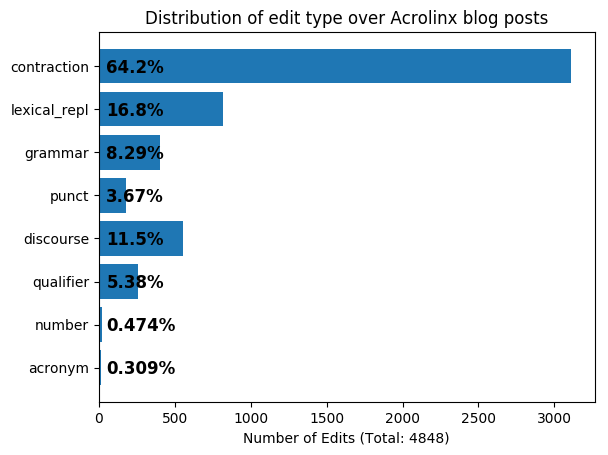

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
cats = ('contraction', 'lexical_repl', 'grammar', 'punct', 'discourse', 'qualifier', 'number', 'acronym')
y_pos = np.arange(len(cats))
vals = np.array([sum(edit_df[item]*edit_df['count']) for item in cats])

ax.barh(y_pos, vals, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(cats)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Edits (Total: ' + str(sum(edit_df['count'])) + ')')
ax.set_title('Distribution of edit type over Acrolinx blog posts')

for i, v in enumerate(vals):
    perc = '%s' % float('%0.3g' % (v / sum(edit_df['count']) * 100))
    ax.text(50, i + .15, str(perc) + '%', color='black', fontweight='bold', fontsize='large')
    
#plt.savefig('data/Acrolinx Blog Posts/distr_fig')
plt.show()

In [ ]:
edit_df.sample(10)

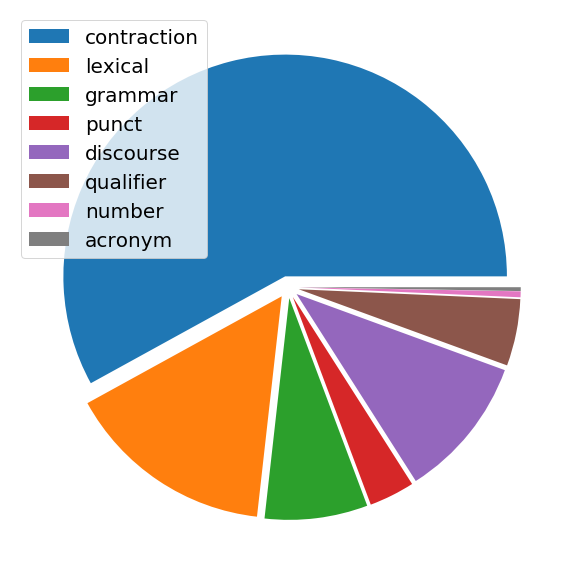

In [80]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
explode = tuple([0.05] * len(vals)) 

plt.figure(figsize=(10, 10), dpi=72)
plt.pie(vals, explode = explode)
plt.legend(labels= ('contraction', 'lexical', 'grammar', 'punct', 'discourse', 'qualifier', 'number', 'acronym')
, loc=2, prop={'size': 20})

plt.savefig('data/acrolinx_blog/pie_fig')

plt.show()

In [14]:
edit_df.to_pickle('data/Acrolinx Blog Posts/organized_edits.pkl')

# Access data for discourse markers and lexical replacement.

Now, I extract the specific examples relevant to the approaches I've chosen.

In [3]:
edit_df = pd.read_pickle('data/acrolinx_blog/organized_edits.pkl')
acro_df = pd.read_pickle('data/acrolinx_blog/acrolinx_blog_annotated_df.pkl')

In [22]:
disc = list(edit_df[edit_df.discourse == True].original)
lexi = list(edit_df[edit_df.lexical_repl == True].original)

In [24]:
disc_val = []
lexi_val = []

for idx, row in tqdm(acro_df.iterrows(), total = len(acro_df)):
    text = row['Original'] + ' ' + row['Replacement']
    if text in disc:
        disc_val.append(True)
    else:
        disc_val.append(False)
    if text in lexi:
        lexi_val.append(True)
    else:
        lexi_val.append(False)

acro_df['lexical'] = lexi_val
acro_df['discourse'] = disc_val

In [30]:
acro_df = acro_df[list(acro_df.lexical) or list(acro_df.discourse)].copy()

In [32]:
print(len(acro_df[acro_df.lexical]))
print(len(acro_df[acro_df.discourse]))

816
33


In [34]:
acro_lex_df = acro_df[acro_df.lexical].drop(['lexical', 'discourse'], axis = 1)

In [37]:
acro_lex_df = acro_lex_df.drop_duplicates(subset = ['Original'])

In [38]:
len(acro_lex_df)

441

## process fragment translation data for testing in model.

I want to use the appropriate Acrolinx blog post data as proof of concept (ish) for the fragment-location and translation model. Here, I transform the data into a format that the model can take.

In [40]:
from nltk import word_tokenize

In [42]:
def make_array(seq_len, last_idx, len_orig):
    arr = [0] * seq_len
    for x in range(len_orig):
        arr[last_idx] = 1
        last_idx -= 1
    return arr

In [50]:
make_array(5, 1, 2)

[1, 1, 0, 0, 0]

In [54]:
sent_tokens = []
orig_tokens = []
orig_indices = []
repl_tokens = []

for idx, row in acro_lex_df.iterrows():
    tokens = word_tokenize(row['Sentence'])
    orig = word_tokenize(row['Original'])
    repl = word_tokenize(row['Replacement'])
    
    orig_idx = 0
    for tok_idx in range(len(tokens)):
        if tokens[tok_idx] == orig[orig_idx]:
            if orig_idx == len(orig) - 1:
                marks = make_array(len(tokens), tok_idx, len(orig))
                break
            orig_idx += 1
            
    orig_indices.append(marks)
    sent_tokens.append(tokens)
    orig_tokens.append(orig)
    repl_tokens.append(repl)

In [55]:
acro_test_df = pd.DataFrame()
acro_test_df['sent'] = sent_tokens
acro_test_df['orig'] = orig_tokens
acro_test_df['repl'] = repl_tokens
acro_test_df['mark'] = orig_indices

In [57]:
acro_test_df.sample(5)

,sent,orig,repl,mark
184,"[Instead, ,, you, need, to, be, part, of, an, ...","[you, must]","[you, 've, got, to]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
215,"[That, sounds, silly, ,, right, ?]",[silly],[insane],"[0, 0, 1, 0, 0, 0]"
331,"[The, problem, with, this, thinking, is, that,...","[their, size]","[whether, they, 're, big, or, small]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
409,"[If, you, think, that, sounds, too, pompous, o...",[or],[/],"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
332,"[One, of, the, most, enjoyable, collections, o...","[most, enjoyable]",[best],"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [58]:
acro_test_df.to_pickle('data/lexical_repl/acro_test_df.pkl')